In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,MaxPool2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.optimizers.legacy import RMSprop,Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical


import os
import random
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
plt.style.use('ggplot')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,precision_score,recall_score

In [2]:
try:
    GPUlist = tf.config.list_physical_devices('GPU')
    print(GPUlist)
    for i in GPUlist:
        tf.config.experimental.set_memory_growth(i, True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
trainCSV = pd.read_csv('train.csv')
testCSV = pd.read_csv('test.csv')
trainCSV.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
trainY = trainCSV['label']
trainX = trainCSV.drop(columns=['label'], axis=1)
trainX = trainX/255.0
testX = testCSV/255.0

In [5]:
trainX = trainX.values.reshape(-1,28,28,1)
testX = testX.values.reshape(-1,28,28,1)
trainY = to_categorical(trainY, num_classes = 10)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.2)

print("trainX:", trainX.shape)
print("testX:", testX.shape)
print("trainY:", trainY.shape)

trainX: (33600, 28, 28, 1)
testX: (28000, 28, 28, 1)
trainY: (33600, 10)


In [6]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size = (7,7), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size = (5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size = (3,3), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size = (3,3), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [7]:
model.compile(optimizer=Adam(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# earlystop = EarlyStopping(monitor='val_loss',patience=4,verbose=1)
callbacks = [learning_rate_reduction] #+ [earlystop]

/Users/sauraku/mambaforge/envs/mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=False,
                                   fill_mode='nearest')

In [9]:
epochs = 30
batch_size = 64

history = model.fit(train_datagen.flow(trainX,trainY, batch_size=batch_size),
    epochs = epochs, validation_data = (valX , valY) ,
    steps_per_epoch=trainX.shape[0] // batch_size,callbacks=callbacks)


Epoch 1/30
525/525 [==============================] - 13s 24ms/step - loss: 2.2639 - accuracy: 0.2204 - val_loss: 1.6494 - val_accuracy: 0.3783 - lr: 0.0100
Epoch 2/30
525/525 [==============================] - 13s 24ms/step - loss: 1.6905 - accuracy: 0.3575 - val_loss: 1.1364 - val_accuracy: 0.6664 - lr: 0.0100
Epoch 3/30
525/525 [==============================] - 13s 24ms/step - loss: 0.9709 - accuracy: 0.6638 - val_loss: 0.6821 - val_accuracy: 0.8443 - lr: 0.0100
Epoch 4/30
525/525 [==============================] - 13s 24ms/step - loss: 0.4626 - accuracy: 0.8711 - val_loss: 0.1923 - val_accuracy: 0.9460 - lr: 0.0100
Epoch 5/30
525/525 [==============================] - 13s 24ms/step - loss: 0.3052 - accuracy: 0.9182 - val_loss: 0.2333 - val_accuracy: 0.9481 - lr: 0.0100
Epoch 6/30
525/525 [==============================] - 12s 23ms/step - loss: 0.2734 - accuracy: 0.9276 - val_loss: 0.1808 - val_accuracy: 0.9530 - lr: 0.0100
Epoch 7/30
525/525 [==============================] - 12s 

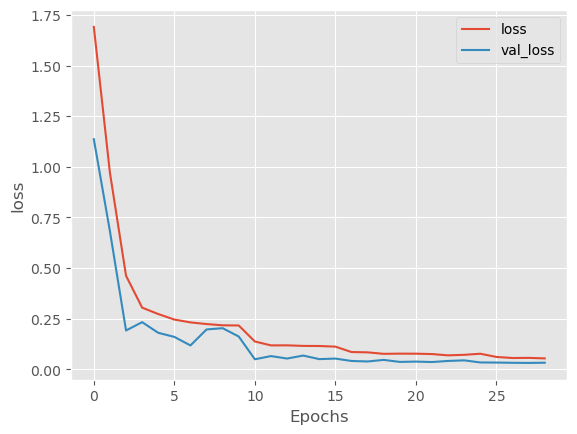

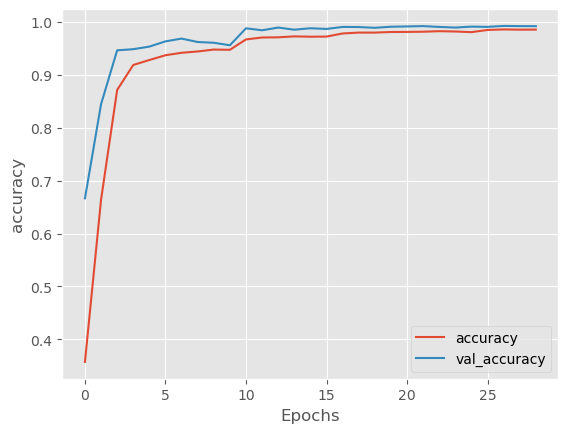

In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string][1:])
    plt.plot(history.history["val_"+string][1:])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'loss')
plot_graphs(history,'accuracy')

In [11]:
results = model.predict(testX)

875/875 [==============================] - 6s 7ms/step


In [12]:
len(results)

28000

In [13]:
results = np.argmax(results,axis = 1)
results = pd.DataFrame({"ImageId":[i for i in range(1,28001)], "Label":results})
results.to_csv("results.csv",index=False)